In [1]:
import torch
import torch.nn.functional as F
from torch import nn, einsum


from einops import rearrange

In [2]:
import os
import sys

# chaging directory

root, *_ = !pwd

if root.endswith('notebooks'):
    os.chdir('../')
    root, *_ = !pwd
    sys.path.append('src/')

os.getcwd()

'/home/med/projects/competitions/mlb-kaggle'

In [3]:
from typing import List

class EmbeddingLayer(nn.Module):
    def __init__(self, categories: List[int],
                 feature_dim: int,
                 dropout: float = 0.,
                 pad_value: int = 0):
        super().__init__()

        categories = torch.tensor(list(categories))
        offset_categories = F.pad(categories, (1, 0), value=pad_value).cumsum(dim=-1)[: -1]
        self.register_buffer('offset_categories', offset_categories)
        self.dropout = nn.Dropout(dropout)
        self.emb = nn.Embedding(sum(categories) + pad_value, feature_dim)
        
        self.output_dim = len(categories) * feature_dim

    def forward(self, x):
        output = self.emb(x + self.offset_categories)
        output = self.dropout(output)
        return output

In [5]:
class Residual(nn.Sequential):
    def forward(self, x: torch.tensor):
        return x + super().forward(x)


def build_feed_forward_bottleneck(input_features: int, expand_size: int = 2,
                                  dropout: int = 0.):
    return nn.Sequential(nn.Linear(input_features, input_features * expand_size),
                         nn.ReLU(),
                         nn.Dropout(dropout),
                         nn.Linear(input_features * expand_size, input_features))
    

    

In [6]:
class Attention(nn.Module):
    def __init__(self, input_dim: int, heads: int,
                 head_features: int,
                 dropout: float = 0.):
        super().__init__()
        total_head_features = head_features * heads
        self.heads = heads
        self.scale_factor = head_features ** -0.5 # -> 1/sqrt(head_features)
        self.to_qkv = nn.Linear(input_dim, total_head_features * 3, bias=False)
        self.decoder = nn.Linear(total_head_features, input_dim)
        
        self.dropout = nn.Dropout(dropout)
    
    def _reshape(self, x: torch.tensor, h: int = None):
        if h is None:
            h = self.heads
        return rearrange(x, 'b sq (h f) -> b h sq f', h=h)
    
    def compute_attn(self, x: torch.tensor):
        # shape of x -> bs, sq, features
        heads = self.heads
        query, key, values = self.to_qkv(x).chunk(3, dim=-1)
        
        
        # input -> bs, sq, (heads * head_features)
        # output -> bs, heads, sq, head_features
        query, key, values = map(self._reshape, (query, key, values))
        
        # attn
        attn = einsum('b h q f, b h k f -> b h q k', query, key)
        # scaling
        attn *= self.scale_factor
        attn = torch.softmax(attn, dim=-1)
        attn = self.dropout(attn)
        
        # attn @ values matrix wise
        output = einsum('b h q v, b h v f -> b h q f', attn, values)
        # input -> bs, heads, sq, features
        # output -> bs, sq, heads * features
        output = rearrange(output, 'b h sq f -> b sq (h f)', h=heads)
        return output, attn
        
    def forward(self, x: torch.tensor):
        output, _ = self.compute_attn(x)
        return self.decoder(output)        

In [7]:
class Transformer(nn.Module):
    def __init__(self, input_features: int,
                 head_features: int, 
                 depth: int,
                 heads: int,
                 attn_dropout: float = 0.,
                 ff_dropout: float = 0.):
        super().__init__()
        self.input_features = input_features
        self.head_features = head_features
        self.attn_dropout = attn_dropout
        self.ff_dropout = ff_dropout
        self.heads=heads
        
        self.net = nn.Sequential(*[self.build_layer()
                                    for _ in range(depth)])
        

    def build_layer(self):
        attn_layer = Residual(nn.LayerNorm(self.input_features),
                              Attention(input_dim=self.input_features,
                                        heads=self.heads,
                                        head_features=self.head_features,
                                        dropout=self.attn_dropout))
        
        feed_forward = build_feed_forward_bottleneck(self.input_features,
                                                     dropout=self.ff_dropout)
        decoder_layer = Residual(nn.LayerNorm(self.input_features),
                                 feed_forward)
        
        return nn.Sequential(attn_layer, decoder_layer)
    
    def forward(self, x: torch.tensor):
        return self.net(x)
        
        

In [189]:
# import pytorch_lightning as pl
# from torch import nn, optim

# def mae(yhat, y):
#     return torch.abs(yhat-y).mean()


# class MLBTransformer(pl.LightningModule):
#     def __init__(self, 
#                  static_features: int,
#                  time_features: int,
#                  categories: List[int],
#                  emb_features: int,
#                  encoder_dim: int,
#                  heads: int = 1,
#                  depth: int = 1,
#                  head_features: int = 8,
#                  ff_dropout: float = 0.,
#                  attn_dropout: float =0.,
#                  emb_dropout: float = 0.,
#                  decoder_dropout: float = 0.,
#                  lr: float = 0.01,
#                  wd: float = 0.,
#                  out_features: int = 1,
#                  decoder_depth: int = 2):
#         super().__init__()
        
#         self.lr = lr
#         self.wd = wd
 
#         self.emb = EmbeddingLayer(categories, emb_features, 
#                                   dropout=emb_dropout, pad_value=1)
#         input_features = self.emb.output_dim + time_features
        
#         self.transformer = Transformer(input_features=input_features,
#                                        head_features=head_features,
#                                        heads=heads,
#                                        depth=depth,
#                                        attn_dropout=attn_dropout,
#                                        ff_dropout=ff_dropout)
        
#         # decoder
#         input_decoder = static_features + input_features
#         self.output_layer = nn.Sequential(nn.Linear(input_decoder, encoder_dim),
#                                           nn.ReLU(),
#                                           nn.BatchNorm1d(encoder_dim),
#                                           nn.Dropout(decoder_dropout),
#                                           nn.Linear(encoder_dim, out_features))
    
#     def forward(self,
#                 time_features,
#                 categories,
#                 static_features=None,
#                 target=None):

#         bs, sq, ft = time_features.size()
#         categories = self.emb(categories)
#         # flatten last dimension
#         categories = categories.flatten(2)

        
#         # append categories to time features
#         features = (torch.cat((time_features, categories), dim=-1)
#                     if time_features is not None else
#                     categories)
        
# #         return features
#         features = self.transformer(features)
        
        
#         features = features[:, -1, :]
#         features = torch.cat((features, static_features), dim=-1)
        
#         prediction = self.output_layer(features)
        
# #         prediction = torch.sigmoid(prediction) * 100
#         return prediction

#     def training_step(self, batch, batch_idx):
#         y_hat = self(**batch)
#         loss = mae(y_hat, batch['target'])
#         self.log('train_mae', loss, on_epoch=True,
#                  prog_bar=True, sync_dist=True)
#         return loss

#     def validation_step(self, batch, batch_idx):
#         y_hat = self(**batch)
#         loss = mae(y_hat, batch['target'])
#         self.log('valid_mae', loss, on_epoch=True,
#                  prog_bar=True, sync_dist=True)
#         return loss

#     def configure_optimizers(self):
#         optimizer = optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.wd)
#         return optimizer
        

In [ ]:
import pytorch_lightning as pl
from torch import nn, optim

def mae(yhat, y):
    return torch.abs(yhat-y).mean()


class MLBTransformer(pl.LightningModule):
    def __init__(self, 
                 static_features: int,
                 time_features: int,
                 categories: List[int],
                 emb_features: int,
                 encoder_dim: int,
                 heads: int = 1,
                 depth: int = 1,
                 head_features: int = 8,
                 ff_dropout: float = 0.,
                 attn_dropout: float =0.,
                 emb_dropout: float = 0.,
                 decoder_dropout: float = 0.,
                 lr: float = 0.01,
                 wd: float = 0.,
                 out_features: int = 1,
                 decoder_depth: int = 2):
        super().__init__()
        
        self.lr = lr
        self.wd = wd
 
        self.emb = EmbeddingLayer(categories, emb_features, 
                                  dropout=emb_dropout, pad_value=1)
        input_features = self.emb.output_dim + time_features
        
        self.transformer = Transformer(input_features=input_features,
                                       head_features=head_features,
                                       heads=heads,
                                       depth=depth,
                                       attn_dropout=attn_dropout,
                                       ff_dropout=ff_dropout)
        
        # decoder
        input_decoder = static_features + input_features
        self.output_layer = nn.Sequential(nn.Linear(input_decoder, encoder_dim),
                                          nn.ReLU(),
                                          nn.BatchNorm1d(encoder_dim),
                                          nn.Dropout(decoder_dropout),
                                          nn.Linear(encoder_dim, out_features))
    
    def forward(self,
                time_features,
                categories,
                static_features=None,
                target=None):

        bs, sq, ft = time_features.size()
        categories = self.emb(categories)
        # flatten last dimension
        categories = categories.flatten(2)

        
        # append categories to time features
        features = (torch.cat((time_features, categories), dim=-1)
                    if time_features is not None else
                    categories)
        
#         return features
        features = self.transformer(features)
        
        
        features = features[:, -1, :]
        features = torch.cat((features, static_features), dim=-1)
        
        prediction = self.output_layer(features)
        
#         prediction = torch.sigmoid(prediction) * 100
        return prediction

    def training_step(self, batch, batch_idx):
        y_hat = self(**batch)
        loss = mae(y_hat, batch['target'])
        self.log('train_mae', loss, on_epoch=True,
                 prog_bar=True, sync_dist=True)
        return loss

    def validation_step(self, batch, batch_idx):
        y_hat = self(**batch)
        loss = mae(y_hat, batch['target'])
        self.log('valid_mae', loss, on_epoch=True,
                 prog_bar=True, sync_dist=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.wd)
        return optimizer
        

In [8]:
# features = 10
# categories = [25, 25, 25]



# model = MLBTransformer(static_features=features,
#                        categories=categories,
#                       time_features=features, emb_features=32, encoder_dim=128,
#                        heads=2, depth=2, head_features=32, out_features=4)

In [9]:
from torch.utils.data import DataLoader
import torch
from typing import Dict, List
import numpy as np
import pandas as pd


def get_timeseries_index(values: np.ndarray,
                         idx: int,
                         bptt: int):

    start_idx = max(0, idx - bptt)
    timeft = values[start_idx: idx + 1]
    
    if len(timeft) <= bptt:
        missing_steps = bptt - len(timeft) + 1
        timeft = np.pad(timeft, pad_width=((missing_steps, 0), (0, 0)))
    
    return timeft
    


class PlayerDataset:
    def __init__(self, features: np.ndarray,
                 time_features: np.ndarray,
                 categories: np.ndarray,
                 target: np.ndarray = None,
                 bptt: int = 10,
                 device: torch.device = torch.device('cpu')):
        self.features = features
        self.time_features = time_features
        self.target = target
        self.bptt = bptt - 1
        self.device = device
        self.categories = categories
        assert len(self) > self.bptt, f'lenght: {len(self)}, bptts: {self.bptt}'
        
    def __len__(self):
        return len(self.features)
    
    def _to_torch(self, array):
        return torch.from_numpy(np.asarray(array)).to(device=self.device)
    
    def to_device(self, batch_item: Dict[str, np.ndarray]):
        return {name: self._to_torch(values)
                for name, values in batch_item.items()}
    
    def __getitem__(self, idx: int):
        
        timeft = get_timeseries_index(self.time_features, idx, self.bptt)
        cats = get_timeseries_index(self.categories, idx, self.bptt)
            
        features = self.features[idx]
        
        batch_item = {'static_features': features,
                      "time_features": timeft,
                      'categories': cats}

        if self.target is not None:
            batch_item['target'] = self.target[idx]
    
        return self.to_device(batch_item)

    @classmethod
    def from_df(cls, df: pd.DataFrame,
                features: List[str],
                time_features: List[str],
                categories: List[str],
                target: List[str]=None,
                bptt: int = 30,
                device: torch.device = torch.device('cpu')):
        
        if target is not None:
            target = df.loc[:, target].to_numpy()
    
        return cls(features=df.loc[:, features].to_numpy(),
                categories=df.loc[:, categories].to_numpy(),
                time_features=df.loc[:, time_features].to_numpy(),
                target=target,
                bptt=bptt,
                device=device)


In [10]:
## reading data

In [11]:
from pathlib import Path
from dotenv import load_dotenv
load_dotenv()

RAW_PATH = Path(os.environ['RAW_PATH'])

In [12]:
PROCESSED_PATH = Path(os.environ['ROOT_DIR']) / 'processed'

In [13]:
os.listdir(PROCESSED_PATH)

['target.csv', 'raw_data.csv']

In [14]:
os.listdir(RAW_PATH)

['seasons.csv',
 'teams.csv',
 'example_sample_submission.csv',
 'train.csv',
 'mlb-player-digital-engagement-forecasting.zip',
 'awards.csv',
 'players.csv',
 'example_test.csv',
 'mlb']

In [15]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import seaborn as sns

In [16]:
df = pd.read_csv(PROCESSED_PATH / 'raw_data.csv', parse_dates=['date'])

/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (84) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [17]:
df.head()

,playerId,target1,target2,target3,target4,date,target_avg,battingOrder,gamesPlayedBatting,flyOuts,...,assists,putOuts,errors,chances,rosterDate,teamId,status,numberOfFollowers,awardId,teamFollowers
0,112526,0.055277,5.496109,0.025839,16.176471,2018-01-01,5.438424,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,112526,0.060625,3.252914,0.030486,8.541353,2018-01-02,2.971345,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,112526,0.029341,1.648352,0.032613,10.490112,2018-01-03,3.050104,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,112526,0.014799,2.665894,0.087422,19.091467,2018-01-04,5.464896,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,112526,0.083916,1.161002,0.024759,6.643880,2018-01-05,1.978389,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
### time and player data 

_players = pd.read_csv(RAW_PATH / 'players.csv')

_players['playerForTestSetAndFuturePreds'].fillna(False, inplace=True)

player_in_test = _players.query('playerForTestSetAndFuturePreds')['playerId']

In [19]:
### target 

from data.ingest_data import player_stats_features
from data.util import filter_by_id

In [20]:
df = filter_by_id(df, player_in_test)

playerList = df.groupby(['playerId'])['target_avg'].std().sort_values(ascending=False).reset_index()

playerList

df = filter_by_id(df, playerList['playerId'].head(50))

df.playerId.nunique()

50

In [21]:
playerList

,playerId,target_avg
0,547180,18.775985
1,660271,18.055585
2,545361,17.410036
3,605141,17.236386
4,592450,16.850044
...,...,...
1182,593590,0.119988
1183,656458,0.115664
1184,676424,0.094298
1185,641927,0.086976


In [22]:
### preprocessing 
from typing import List
def forward_fill(df: pd.DataFrame, features: List[str],
                 on='playerId',
                 limit: int =None):
    ffilled_df = df.groupby(on)[features].ffill(limit=limit)
    df.loc[:, features] = ffilled_df
    return df

In [23]:
def gen_hardcoded_features(df: pd.DataFrame):
    # some feature eng for the dates
    df['playerAge'] = (df['date'] - df['DOB']).dt.total_seconds()
    df['playerTSinceDebut'] = (df['date'] - df['mlbDebutDate']).dt.total_seconds()
    df['playerDebutAge'] = (df['mlbDebutDate'] - df['DOB']).dt.total_seconds()
    df['rostersTime'] = (df['date'] - pd.to_datetime(df['rosterDate'])).dt.total_seconds()
    df['rostersTime'] /= 60 * 60 * 24
    # normalize
    df[['playerAge', 'playerTSinceDebut', 'playerDebutAge']] /= 60 * 60 * 24 * 365
    df['AwardWinner'] = df['awardId'].isna().astype(np.float64)
    return df

def fillna(df: pd.DataFrame, fill_value=-1):
    return df.fillna(-1)

In [24]:
from pipeline.core import FunctionTransformer, Pipeline, PdColumnTransformer, PdFeatureUnion
from pipeline.continuous import PdScaleNorm, FilterContinuousFeatures, MedianFillNaN
from pipeline.stats import StatisticGen, LagGen, FeaturesTable
from pipeline.categories import Categorify
from pipeline.season import join_season_info
from pipeline.players import join_players_info

In [25]:
# transformer for joining data and create base features
fill_forward_tmf = FunctionTransformer(forward_fill, kw_args={'features':['numberOfFollowers',
                                                                        'teamFollowers',
                                                                        'status',
                                                                        'teamId',
                                                                          'rosterDate']})
join_season_tmf = FunctionTransformer(join_season_info,
                                      kw_args={'path_to_season': RAW_PATH / 'seasons.csv',
                                             'date_attr': ['year', 'month']})
join_players_tmf = FunctionTransformer(join_players_info, kw_args={'path_to_players': RAW_PATH / 'players.csv'})
harcoded_feat_tmf = FunctionTransformer(gen_hardcoded_features)

# creating pipeline
join_and_compute_feat_pl = Pipeline([('season', join_season_tmf),
                                     ('players', join_players_tmf),
                                     ('fill_forward', fill_forward_tmf),
                                     ('hardcoded_feat', harcoded_feat_tmf)])

In [26]:
# features to use for target preprocessing
target_cols = ['target1', 'target2', 'target3', 'target4']
index_cols = ['date', 'playerId']
pp_cols = target_cols + index_cols

# categories encoding
categories = ['playerId', 'seasonPart',
              'primaryPositionName', 'teamId']

categories_tmf = PdColumnTransformer([(category, Categorify(add_nan=True), category)
                                       for category in categories])

In [27]:
from sklearn.preprocessing import KBinsDiscretizer
class PdKBinsDiscretizer(KBinsDiscretizer):
    def __init__(self, n_bins: int, strategy: str = 'quantile'):
        super().__init__(n_bins=n_bins, strategy=strategy, encode='ordinal')
        
    def fit(self, X: pd.DataFrame, y=None):
        self._features = list(X.columns)
        return super().fit(X, y)

    def transform(self, X: pd.DataFrame):
        outputX = super().transform(X).astype(np.int64)
        outputX = pd.DataFrame(outputX, columns=self._features)
        return outputX

In [241]:
## merge computed statistics

kbins_tmf = PdKBinsDiscretizer(n_bins=10)
lagger_tmf = PdColumnTransformer([('lags', LagGen([1]), pp_cols)])

stats_feat_tmf = Pipeline([('lagger_tmf', lagger_tmf),
                           ('fillnan', FunctionTransformer(fillna)),
#                             ('discretize', kbins_tmf)  
                          ])

In [242]:
# continuous preprocessing

median_fillnan_columns = ['numberOfFollowers', 'teamFollowers',
                          'playerDebutAge', 'playerAge', 'playerTSinceDebut']
fillnan_median_tmf = MedianFillNaN(median_fillnan_columns)

# get the rest of the continuous features
continuous_feat_tmf = Pipeline([('get_cont_feat', FilterContinuousFeatures()),
                                ('fillnan_median', fillnan_median_tmf),
                                ('fillnan', FunctionTransformer(fillna)),
                                ('normalize', PdScaleNorm())
                               ])

In [243]:
from statsmodels.tsa.deterministic import (CalendarFourier,
                                           DeterministicProcess)

In [244]:
def add_fourier_seasonality(X: pd.DataFrame,
                            dt_col: str = 'date', 
                            order: int = 4):
    fourier_terms = CalendarFourier(freq='A', order=order)
    deterministic = DeterministicProcess(
        index=X[dt_col].values,
        order=0,
        seasonal=False,  # set to True for weekly seasonality
        additional_terms=[fourier_terms],
    )
    outputX = deterministic.in_sample()
    outputX.reset_index(drop=True, inplace=True)
    return outputX.astype(np.float32)

In [245]:
# putting all together
all_features_tmf = PdFeatureUnion([('target_stats', stats_feat_tmf), 
                                   ('cont_feat', continuous_feat_tmf), 
                                  ('cats', categories_tmf),
                                   ('fourier_stats',FunctionTransformer(add_fourier_seasonality))
                                  ])

In [246]:
# main pipeline with all steps 
pipeline = Pipeline([('join_compute', join_and_compute_feat_pl),
                    ('features_gen', all_features_tmf)])

In [247]:
pipeline

Pipeline(steps=[('join_compute',
                 Pipeline(steps=[('season',
                                  FunctionTransformer(func=<function join_season_info at 0x7f92cdddeaf0>,
                                                      kw_args={'date_attr': ['year',
                                                                             'month'],
                                                               'path_to_season': PosixPath('data/raw/seasons.csv')})),
                                 ('players',
                                  FunctionTransformer(func=<function join_players_info at 0x7f92cdddec10>,
                                                      kw_args={'path_to_players': PosixPath('data/raw/playe...
                                                   PdColumnTransformer(transformers=[('playerId',
                                                                                      Categorify(add_nan=True),
                                                     

In [248]:
from data.split import SplitData

sp = SplitData("2021-03-01", test_days=61)

train_idx = sp.train_idx(df)
valid_idx = sp.valid_idx(df)

In [249]:
%%time
pipeline.fit(sp.filter(df, train_idx))

CPU times: user 333 ms, sys: 30.4 ms, total: 363 ms
Wall time: 360 ms


Pipeline(steps=[('join_compute',
                 Pipeline(steps=[('season',
                                  FunctionTransformer(func=<function join_season_info at 0x7f92cdddeaf0>,
                                                      kw_args={'date_attr': ['year',
                                                                             'month'],
                                                               'path_to_season': PosixPath('data/raw/seasons.csv')})),
                                 ('players',
                                  FunctionTransformer(func=<function join_players_info at 0x7f92cdddec10>,
                                                      kw_args={'path_to_players': PosixPath('data/raw/playe...
                                                   PdColumnTransformer(transformers=[('playerId',
                                                                                      Categorify(add_nan=True),
                                                     

In [250]:
%%time
features = pipeline.transform(df)

CPU times: user 395 ms, sys: 67 µs, total: 395 ms
Wall time: 392 ms


In [251]:
pd.options.display.max_rows = 100
features.T.head(100)

,0,1,2,3,4,5,6,7,8,9,...,60790,60791,60792,60793,60794,60795,60796,60797,60798,60799
target1__1lag,-1.000000,0.151872,0.136406,0.064460,0.024217,0.157556,0.026125,0.017632,0.015411,0.018681,...,1.568381,0.508591,0.274978,0.089191,0.071602,0.119272,0.669748,0.405739,0.194003,0.169173
target2__1lag,-1.000000,21.449417,10.978585,9.226191,10.170965,4.294307,8.972692,39.196941,23.472429,11.376451,...,5.610395,3.987602,1.694069,3.088712,3.827821,2.352499,3.366465,2.998391,3.822369,2.899817
target3__1lag,-1.000000,0.112952,0.096403,0.101464,0.102448,0.046517,0.077226,0.068476,0.113238,0.110837,...,4.182839,2.380317,0.444142,0.236491,0.392115,0.216761,3.544690,2.609699,0.448111,0.998971
target4__1lag,-1.000000,22.990196,15.669173,23.172829,35.359116,12.347789,23.781010,35.371517,38.888889,10.125261,...,6.453161,8.103130,2.364830,2.242237,1.739181,5.289375,3.747653,4.669960,4.314616,5.209012
battingOrder,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
gamesPlayedBatting,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
flyOuts,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
groundOuts,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
runsScored,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
doubles,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [252]:
continuous_feat = features.columns.drop(categories)

In [253]:
df[target_cols] = df[target_cols].astype(np.float32)

In [254]:
train_idx.shape

(60800,)

In [255]:
train_idx.shape

(60800,)

In [256]:
train_data = sp.filter(features, train_idx)

raw_train_df = sp.filter(df, train_idx)

In [257]:
valid_data = sp.filter(features, valid_idx)
raw_valid_df = sp.filter(df, valid_idx)

In [258]:
train_data.shape, raw_valid_df.shape

((57750, 99), (3050, 86))

In [259]:
valid_data.shape, raw_train_df.shape

((3050, 99), (57750, 86))

In [260]:
train_data[target_cols + ['date']] = raw_train_df[target_cols + ['date']]
valid_data[target_cols + ['date']] = raw_valid_df[target_cols + ['date']]

### modeling 

In [262]:
time_features = [#'battingOrder', 'gamesPlayedBatting', 'flyOuts', 'groundOuts',
#        'runsScored', 'doubles', 'triples', 'homeRuns', 'strikeOuts',
#        'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch', 'atBats',
#        'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
#        'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
#        'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
#        'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
#        'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
#        'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
#        'groundOutsPitching', 'runsPitching', 'doublesPitching',
#        'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
#        'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
#        'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
#        'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
#        'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
#        'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
#        'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
#        'inheritedRunnersScored', 'catchersInterferencePitching',
#        'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
#        'assists', 'putOuts', 'errors', 'chances'] + [
    'target1__1lag',
 'target2__1lag',
 'target3__1lag',
 'target4__1lag',
    'sin(1,freq=A-DEC)',
 'cos(1,freq=A-DEC)',
 'sin(2,freq=A-DEC)',
 'cos(2,freq=A-DEC)',
 'sin(3,freq=A-DEC)',
 'cos(3,freq=A-DEC)',
 'sin(4,freq=A-DEC)',
 'cos(4,freq=A-DEC)']

In [263]:
categories = [
             'playerId']

In [264]:
static_features = ['numberOfFollowers',
 'teamFollowers',
 'weight',
 'height',
 'playerBMI',
 'playerAge',
 'playerTSinceDebut',
 'playerDebutAge',
 'rostersTime',
 'AwardWinner',]#list(features.columns.drop(categories + time_features + [


In [265]:
static_features

['numberOfFollowers',
 'teamFollowers',
 'weight',
 'height',
 'playerBMI',
 'playerAge',
 'playerTSinceDebut',
 'playerDebutAge',
 'rostersTime',
 'AwardWinner']

In [266]:
batch_size = 512
bptt = 14

In [267]:
train_ds = PlayerDataset.from_df(train_data,
                                  features=static_features,
                                  time_features=time_features,
                                  categories=categories,
                                  target=target_cols,
                                  bptt=bptt)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                      num_workers=4)

valid_ds = PlayerDataset.from_df(valid_data, 
                                  features=static_features,
                                  time_features=time_features,
                                  categories=categories,
                                  target=target_cols,
                                  bptt=bptt)
valid_dl = DataLoader(valid_ds, batch_size=batch_size,
                      shuffle=False, num_workers=4)

In [268]:
batch = next(iter(valid_dl))

In [269]:
epochs=10

In [270]:
train_data.loc[:, categories].nunique()

playerId    50
dtype: int64

In [271]:
emb_szs = list(train_data.loc[:, categories].nunique() + 1)

In [272]:
model = MLBTransformer(static_features=len(static_features),
                       categories=emb_szs,
                       time_features=len(time_features),
                       emb_features=8,
                       encoder_dim=128,
                       heads=6,
                       depth=2,
                       head_features=16,
                       out_features=len(target_cols),
                       lr=0.001,
                       wd=3e-5,
                       attn_dropout=0.2,
                       ff_dropout=0.2,
                       decoder_dropout=0.2,
                      emb_dropout=0.5)

In [273]:
model

MLBTransformer(
  (emb): EmbeddingLayer(
    (dropout): Dropout(p=0.5, inplace=False)
    (emb): Embedding(52, 8)
  )
  (transformer): Transformer(
    (net): Sequential(
      (0): Sequential(
        (0): Residual(
          (0): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
          (1): Attention(
            (to_qkv): Linear(in_features=20, out_features=288, bias=False)
            (decoder): Linear(in_features=96, out_features=20, bias=True)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
        (1): Residual(
          (0): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
          (1): Sequential(
            (0): Linear(in_features=20, out_features=80, bias=True)
            (1): ReLU()
            (2): Dropout(p=0.2, inplace=False)
            (3): Linear(in_features=80, out_features=20, bias=True)
          )
        )
      )
      (1): Sequential(
        (0): Residual(
          (0): LayerNorm((20,), eps=1e-05, elementwise_affine=Tr

In [274]:
from pytorch_lightning.callbacks import EarlyStopping
early_stopping = EarlyStopping('valid_mae', patience=3)

In [275]:
trainer = pl.Trainer(max_epochs=epochs, callbacks=[early_stopping])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [276]:
trainer.fit(model, train_dl, valid_dl)


  | Name         | Type           | Params
------------------------------------------------
0 | emb          | EmbeddingLayer | 416   
1 | transformer  | Transformer    | 22.2 K
2 | output_layer | Sequential     | 4.7 K 
------------------------------------------------
27.3 K    Trainable params
0         Non-trainable params
27.3 K    Total params
0.109     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/pytorch_lightning/core/step_result.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [277]:
def predict_fn(test_features: pd.DataFrame):
        test_ds = PlayerDataset.from_df(test_features,
                                        features=static_features,
                                        time_features=time_features,
                                        categories=categories,
                                        bptt=bptt)
        test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
        prediction = predict_dl(model, test_dl)
        del test_dl, test_ds
        return prediction

In [278]:
from train.core import ModelOutput, Ensemble, predict_recursive

In [279]:
def predict_dl(model: nn.Module, valid_dl: DataLoader):
    model.eval()
    with torch.no_grad():
        prediction = torch.cat([model(**batch)
                               for batch in valid_dl])
    return prediction.numpy()

In [280]:
prediction = predict_dl(model, valid_dl)
output = ModelOutput(model, predict_fn, prediction)

In [281]:
ensemble = Ensemble([output], pipeline)

In [282]:
from evaluate.metrics import compute_metrics

In [283]:
%%time
# raw_train_fr = raw_train_df.query("date >= '2020-07-01'").reset_index(drop=True)
raw_train_fr = raw_train_df[df.columns]

recursive_prediction = []
for date, val_date_df in raw_valid_df.groupby('date'):
    val_date_df = val_date_df[df.columns].reset_index(drop=True)
    _recurive_pred, raw_train_fr = predict_recursive(val_date_df,
                                                     raw_train_fr,
                                                     ensemble,
                                                     n_days=30,
                                                     target_cols=target_cols)
    
#     raw_train_fr.loc[raw_train_fr['date'] == date, target_cols] = val_date_df[target_cols].to_numpy()
    recursive_prediction.append(_recurive_pred)

recursive_prediction = pd.concat(recursive_prediction, ignore_index=True)
recursive_prediction.sort_values(['playerId', 'date'], inplace=True)
recursive_prediction.reset_index(drop=True, inplace=True)
recursive_prediction.rename(columns={f: f.replace('target', 'yhat')
                                     for f in target_cols}, inplace=True)

assert (recursive_prediction[['playerId', 'date']] == raw_valid_df[['playerId', 'date']]).all().all()
recursive_prediction[target_cols] = raw_valid_df[target_cols].to_numpy()

     target1    target2    target3    target4       date  playerId
0  11.588997  29.618906   6.340325  58.806076 2021-03-01    405395
1  11.365471  10.586914  23.355654  16.273508 2021-03-01    425844
2   1.065719  15.247037   2.565012   6.197366 2021-03-01    446372
3   0.214097   9.154165   0.463258   8.393177 2021-03-01    453286
4   0.733806  12.084947   0.579368   7.443713 2021-03-01    453562
    target1    target2   target3    target4       date  playerId
0  7.913630  27.310423  4.671153  36.321014 2021-03-02    405395
1  5.042125   8.678246  7.793515  11.105505 2021-03-02    425844
2  1.336531  17.197563  2.619699   7.183010 2021-03-02    446372
3  0.308816   9.796884  0.615441   8.059691 2021-03-02    453286
4  0.998637  13.890536  0.715362   8.507080 2021-03-02    453562
    target1    target2   target3    target4       date  playerId
0  5.349148  25.242540  3.350541  27.583090 2021-03-03    405395
1  2.486737   8.458034  3.458634   9.477073 2021-03-03    425844
2  1.492419  

    target1    target2   target3    target4       date  playerId
0  1.451872  51.547611  1.477610  25.028444 2021-03-22    405395
1  0.311291  14.279327  0.745631  10.156329 2021-03-22    425844
2  0.541822  25.765005  0.629601   8.645695 2021-03-22    446372
3  0.280498  16.284262  0.784626  10.235716 2021-03-22    453286
4  0.395602  20.694830  0.779730   9.409166 2021-03-22    453562
    target1    target2   target3    target4       date  playerId
0  1.422690  52.007072  1.497357  24.795536 2021-03-23    405395
1  0.313790  14.557400  0.751297  10.163282 2021-03-23    425844
2  0.541804  26.185564  0.609048   8.646063 2021-03-23    446372
3  0.283806  16.612879  0.790356  10.271530 2021-03-23    453286
4  0.398678  20.980618  0.786574   9.384294 2021-03-23    453562
    target1    target2   target3    target4       date  playerId
0  1.390180  52.399372  1.508951  24.528540 2021-03-24    405395
1  0.317051  14.803413  0.758108  10.143763 2021-03-24    425844
2  0.544196  26.618137  0

    target1    target2   target3    target4       date  playerId
0  0.785679  54.809948  1.684061  20.185268 2021-04-13    405395
1  0.353952  19.636164  0.899074   8.941180 2021-04-13    425844
2  0.574577  37.141678  0.763975   8.373663 2021-04-13    446372
3  0.454527  25.650703  0.917099  10.210157 2021-04-13    453286
4  0.376642  31.763861  0.633906   9.077991 2021-04-13    453562
    target1    target2   target3    target4       date  playerId
0  0.759653  54.756203  1.688246  20.018301 2021-04-14    405395
1  0.354501  19.835596  0.905407   8.876052 2021-04-14    425844
2  0.549947  37.549942  0.791329   8.312330 2021-04-14    446372
3  0.473766  26.215117  0.918597  10.202715 2021-04-14    453286
4  0.343356  32.397854  0.652063   9.128111 2021-04-14    453562
    target1    target2   target3    target4       date  playerId
0  0.734200  54.699310  1.691782  19.857079 2021-04-15    405395
1  0.359025  20.061325  0.912284   8.816442 2021-04-15    425844
2  0.524625  37.926113  0

In [284]:
valid_test_prediction = pd.DataFrame(prediction, columns=['yhat1', 'yhat2', 'yhat3', 'yhat4'])

valid_test_prediction[pp_cols] = raw_valid_df[pp_cols]

is_test_pred = valid_test_prediction['date'] >= '2021-04-01'

valid_prediction, test_prediction = (valid_test_prediction.loc[~is_test_pred, :],
                                     valid_test_prediction.loc[is_test_pred, :])

In [285]:
compute_metrics(valid_test_prediction)

{'mae_mean': 7.0113864,
 'mae_1': 7.3768635,
 'mae_2': 7.265368,
 'mae_3': 6.1158133,
 'mae_4': 7.2875}

In [286]:
compute_metrics(valid_prediction)

{'mae_mean': 6.963891,
 'mae_1': 7.468483,
 'mae_2': 7.3419127,
 'mae_3': 6.107951,
 'mae_4': 6.9372177}

In [287]:
compute_metrics(test_prediction)

{'mae_mean': 7.060465,
 'mae_1': 7.2821903,
 'mae_2': 7.186272,
 'mae_3': 6.1239376,
 'mae_4': 7.64946}

In [288]:
valid_rc_prediction, test_rc_prediction = (recursive_prediction.loc[~is_test_pred, :],
                                           recursive_prediction.loc[is_test_pred, :])

In [289]:
compute_metrics(valid_rc_prediction)

{'mae_mean': 8.948876108970246,
 'mae_1': 8.959014954484527,
 'mae_2': 10.302448577342496,
 'mae_3': 7.232150858188078,
 'mae_4': 9.301890045865889}

In [290]:
compute_metrics(test_rc_prediction)

{'mae_mean': 11.431566873832528,
 'mae_1': 8.556352911787728,
 'mae_2': 21.603368756433326,
 'mae_3': 6.639387523371416,
 'mae_4': 8.92715830373764}

In [291]:
compute_metrics(recursive_prediction)

{'mae_mean': 10.16987156709924,
 'mae_1': 8.760984441682822,
 'mae_2': 15.860278173616676,
 'mae_3': 6.9406279066389,
 'mae_4': 9.117595746458553}

In [292]:
def plot_pred(df, playerId, index=1):
    pdf = df.query(f'playerId == {playerId}')
    
    f, ax = plt.subplots(1, 1, figsize=(20, 5))
    
    tname = f'target{index}'
    yhat_name = f'yhat{index}'
    
    ax.plot('date', tname, '-o', data=pdf, label=tname)
    ax.plot('date', yhat_name, '-o', data=pdf, label=tname)
    
    ax.legend()
    

In [293]:
(recursive_prediction.groupby('playerId')
 .apply(lambda x: pd.Series(compute_metrics(x)))
 .sort_values(by='mae_mean', ascending=False)).head(10)

,mae_mean,mae_1,mae_2,mae_3,mae_4
playerId,,,,,
660271,27.589665,26.578110,27.415887,29.509215,26.855447
665487,24.650841,23.386572,28.350680,25.429439,21.436673
596019,19.241028,20.101780,23.374564,16.400290,17.087480
545361,19.016643,14.653657,20.505647,12.589022,28.318247
545333,17.720292,12.664667,29.313090,8.539410,20.364000
605141,16.061683,10.035473,26.723106,8.549700,18.938454
660670,15.863491,22.931583,16.742472,16.204231,7.575679
547180,15.655135,14.816459,20.232032,9.659299,17.912751
594798,15.260533,11.669327,17.435898,14.494176,17.442730


In [294]:
# 22.287758	23.63591	24.933866	23.164949	17.416305

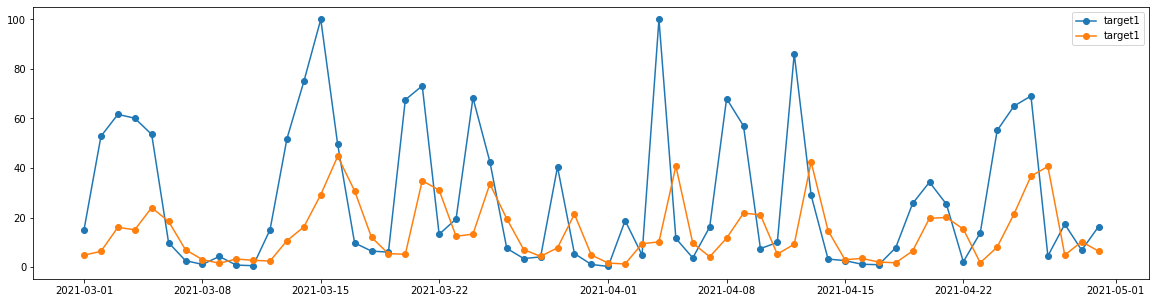

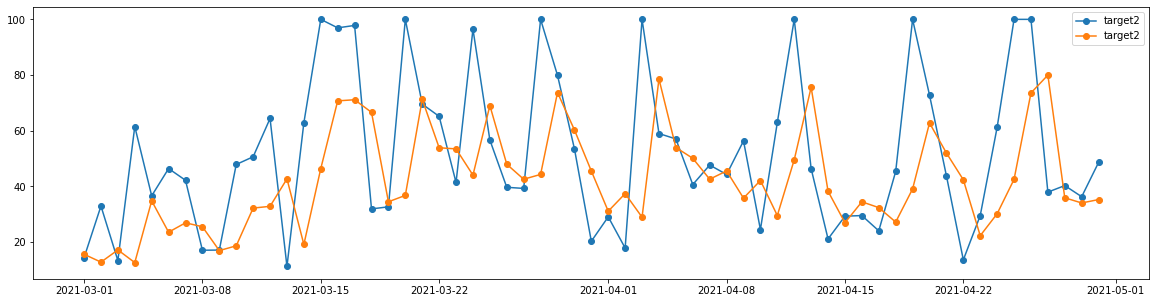

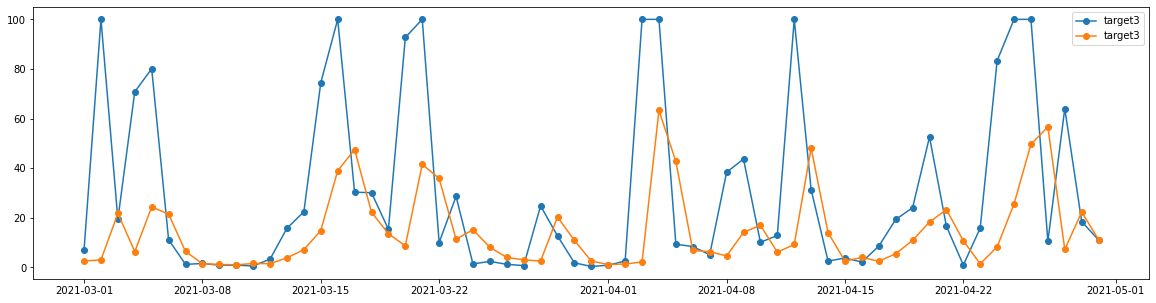

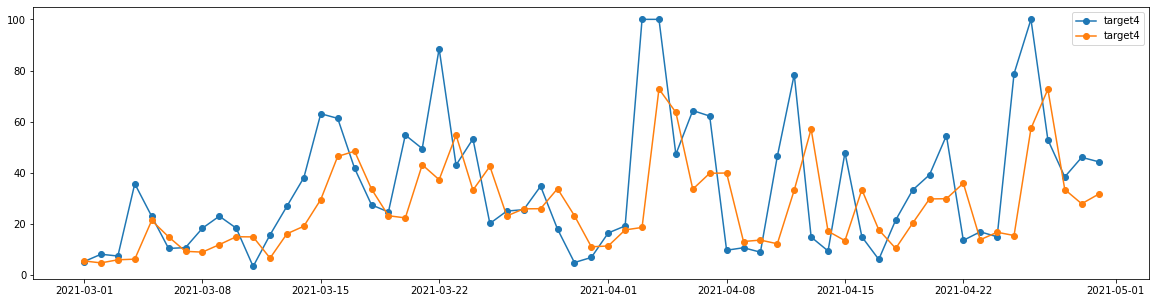

In [295]:
for index in range(1, 5):
    plot_pred(valid_test_prediction, playerId=660271, index=index)

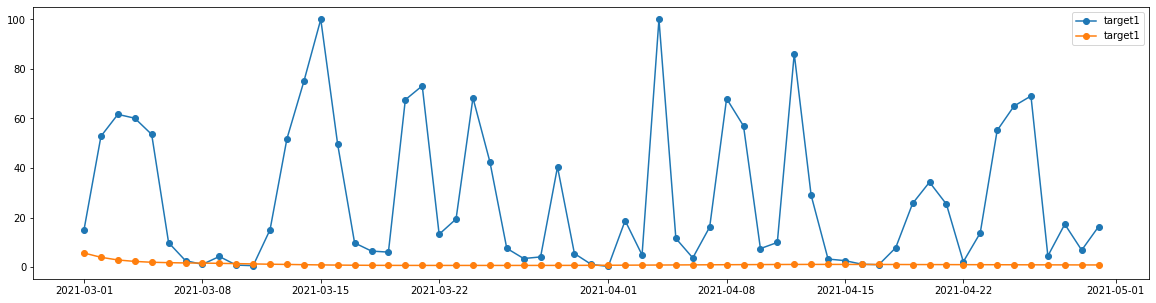

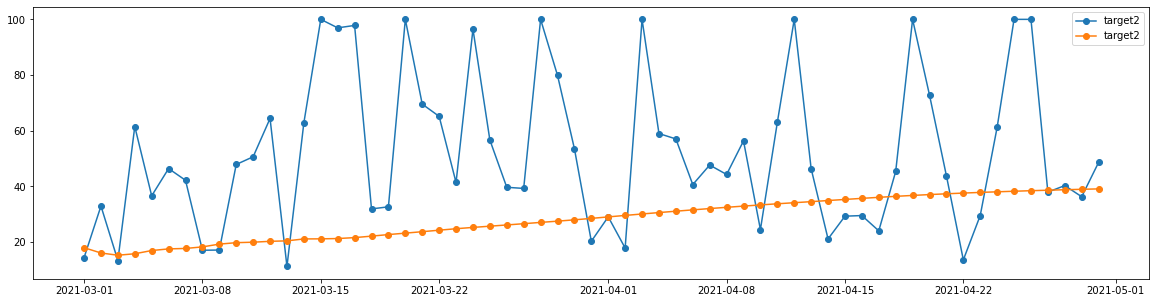

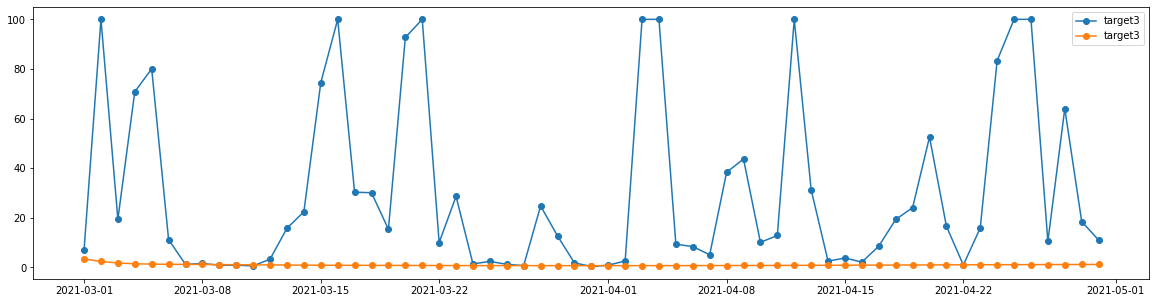

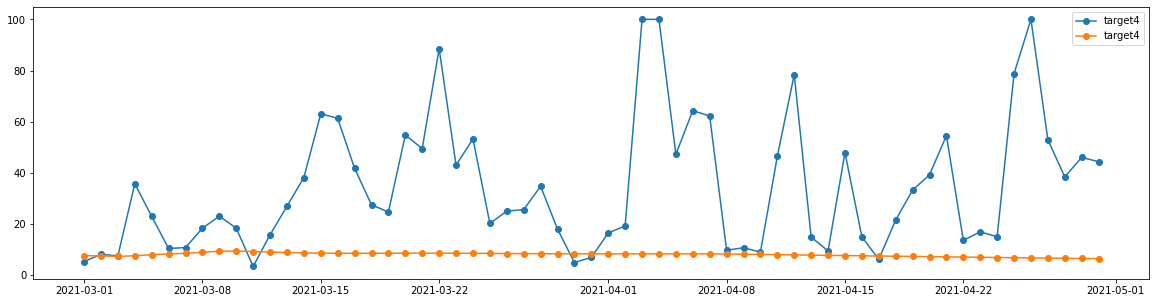

In [296]:
for index in range(1, 5):
    plot_pred(recursive_prediction, playerId=660271, index=index)